Optimal Allocation (in USD) and Number of Shares:
Ticker                                                     Name  Investment  Shares
   GLD                                         SPDR Gold Shares    49984.08     204
   BND                    Vanguard Total Bond Market Index Fund    49982.59     668
  VXUS Vanguard Total International Stock Index Fund ETF Shares    49981.44     768
   AGG                     iShares Core U.S. Aggregate Bond ETF    49932.42     495
   VIG     Vanguard Dividend Appreciation Index Fund ETF Shares    49911.84     253
   SPY                                   SPDR S&P 500 ETF Trust        0.00       0
   IJR                           iShares Core S&P Small-Cap ETF        0.00       0
   RSP                         Invesco S&P 500 Equal Weight ETF        0.00       0
   IWM                                 iShares Russell 2000 ETF        0.00       0
   XLK                   The Technology Select Sector SPDR Fund        0.00       0
    VO                   V

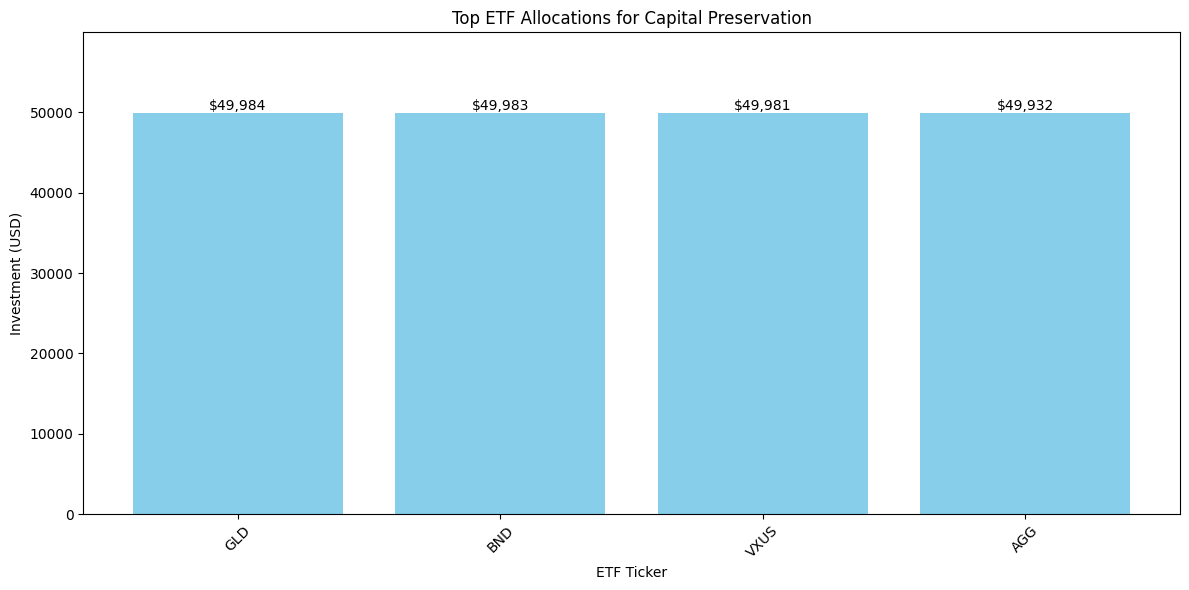

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import cvxpy as cp
import warnings
import math
import matplotlib.pyplot as plt

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define ETF tickers and parameters
etf_tickers = [
    'SPY', 'VOO', 'IVV', 'VTI', 'QQQ', 'VUG', 'VEA', 'VTV', 'IEFA', 'AGG',
    'BND', 'IWF', 'IJH', 'VIG', 'IJR', 'VWO', 'IEMG', 'GLD', 'VGT', 'VXUS',
    'VO', 'XLK', 'IWM', 'RSP', 'SCHD'
]
start_date = "2019-09-30"
end_date = "2024-09-30"
total_investment = 250000  # Total budget in USD
min_return_threshold = 0.02  # Target minimum annual return (2% for preservation)

# Fetch and process data for each ETF
etf_data_list = []
for ticker in etf_tickers:
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if data.empty:
        continue
    data['Daily_Return'] = data['Adj Close'].pct_change().dropna()
    total_return = data['Adj Close'].iloc[-1] / data['Adj Close'].iloc[0] - 1
    num_years = (data.index[-1] - data.index[0]).days / 365.25
    avg_annual_return = (1 + total_return) ** (1 / num_years) - 1 if num_years > 0 else 0.0
    daily_std = data['Daily_Return'].std()
    annualized_risk = daily_std * np.sqrt(252)  # Annualize the daily standard deviation
    latest_price = data['Adj Close'].iloc[-1]

    etf_data_list.append({
        'Ticker': ticker,
        'Price': latest_price.item() if isinstance(latest_price, pd.Series) else float(latest_price),
        'Avg Annual Return': avg_annual_return.item() if isinstance(avg_annual_return, pd.Series) else float(avg_annual_return),
        'Annualized Risk': annualized_risk.item() if isinstance(annualized_risk, pd.Series) else float(annualized_risk)
    })

# Create DataFrame from ETF data
etf_data = pd.DataFrame(etf_data_list, columns=['Ticker', 'Price', 'Avg Annual Return', 'Annualized Risk'])

# Extract returns and risks, set up optimization variables
returns = etf_data['Avg Annual Return'].to_numpy()
risks = etf_data['Annualized Risk'].to_numpy()
n = len(returns)
x = cp.Variable(n)  # Investment in each ETF

# Define objective to minimize total portfolio risk
objective = cp.Minimize(cp.matmul(risks, x))  # Minimize sum(risk_i * x_i)

# Define constraints for LP problem
constraints = [
    cp.sum(x) == total_investment,                                   # Total investment constraint
    x >= 0,                                                          # No short selling
    x <= 0.2 * total_investment,                                     # Max 20% per ETF
    cp.matmul(returns, x) >= min_return_threshold * total_investment  # Minimum return threshold
]

# Solve the LP problem
prob = cp.Problem(objective, constraints)
prob.solve()

# Assign allocations if optimization is successful
if prob.status == cp.OPTIMAL:
    etf_data['Investment'] = x.value
    # Calculate whole shares
    etf_data['Shares'] = (etf_data['Investment'] / etf_data['Price']).apply(math.floor)
    # Recalculate Investment based on whole shares
    etf_data['Investment'] = etf_data['Shares'] * etf_data['Price']

    # Function to fetch the full name of the ETF
    def get_etf_name(ticker):
        try:
            return yf.Ticker(ticker).info.get('longName', 'N/A')
        except Exception as e:
            return 'N/A'

    # Apply the function to get ETF names
    etf_data['Name'] = etf_data['Ticker'].apply(get_etf_name)

    # Create result table with Ticker, Name, Investment, and Shares
    result_table = etf_data[['Ticker', 'Name', 'Investment', 'Shares']].round(2)

    # Sort the table by Investment in descending order
    result_table = result_table.sort_values(by='Investment', ascending=False).reset_index(drop=True)

    # Display the sorted table with ETF names
    print("Optimal Allocation (in USD) and Number of Shares:")
    print(result_table.to_string(index=False))

    # Display summary
    total_investment_calculated = etf_data['Investment'].sum()
    expected_portfolio_return = (etf_data['Investment'] * etf_data['Avg Annual Return']).sum() / total_investment_calculated
    print(f"\nTotal Investment: ${total_investment_calculated:,.2f}")
    print(f"Expected Portfolio Return: {expected_portfolio_return:.2%}")

    # Visualization: Top ETF Allocations
    top_n = 4
    top_etfs = result_table.head(top_n)

    plt.figure(figsize=(12, 6))
    bars = plt.bar(top_etfs['Ticker'], top_etfs['Investment'], color='skyblue')
    plt.xlabel('ETF Ticker')
    plt.ylabel('Investment (USD)')
    plt.title('Top ETF Allocations for Capital Preservation')
    plt.xticks(rotation=45)
    plt.ylim(0, top_etfs['Investment'].max() * 1.2)

    # Adding value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'${height:,.0f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

else:
    print("Optimization unsuccessful.")
    print(f"Status: {prob.status}")